In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack - Distinguishing particles in brightfield

This notebook demonstrates how to use a U-NET to track and distinguish particles of different sizes in brightfield.

This tutorial should be read after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_multiple_particles_unet_tutorial](tracking_multiple_particles_unet_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
from deeptrack.scatterers import Ellipse
from deeptrack.optics import Brightfield, IlluminationGradient
from deeptrack.noises import Poisson
from deeptrack.generators import Generator
from deeptrack.models import unet
from deeptrack.aberrations import Zernike
from deeptrack.augmentation import FlipLR, FlipUD, FlipDiagonal
from deeptrack.math import NormalizeMinMax

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particles

For this example, we consider circular disk particles of two different sizes. The particles are instances of the class `Ellipse`, which takes the following inputs:

* position: The in-sample position of the particle.
* z (optional): The distance of the particle from the focal plane in the direction of the camera. 
* position_unit: "pixel" or "meter", defines the scale factor of the particle position
* radius: The radius of the particle in meters. If two numbers, they define the dimensions of an ellipse.
* rotation (optional): If elliptical, this defines the angle between the first axis of the particle and the x-axis.
* refractive_index / intensity / value: The characteristics of the particle used by the optical system.

The particles' are defined to be randomly sampled between 0 and 256 pixels in the camera plane, and within -10 to 10 pixel units from the focal plane. The smaller particle has a radius between 200-250 nm, while the larger has a radius between 400-500 nm. Their refractive index are both 0.12, with an absorption coefficient between 0.1 and 0.15, determined by the imaginary part of the refractive index. Finally we define a dummy-property, `particle_type`, which helps us distinguish between the particles.

In [3]:
small_particle = Ellipse(
    position=lambda: np.random.rand(2) * 256,
    z=lambda:np.random.rand() * 20 - 10,
    position_unit="pixel", # Defaults to meter
    radius=lambda: np.random.rand() * 0.05e-6 + 0.2e-6,
    refractive_index=lambda: 0.12 + (0.1j + np.random.rand() * 0.05j),
    particle_type = 0
)

large_particle = Ellipse(
    position=lambda: np.random.rand(2) * 256,
    z=lambda:np.random.rand() * 20 - 10,
    position_unit="pixel", # Defaults to meter
    radius=lambda: np.random.rand() * 0.1e-6 + 0.4e-6,
    refractive_index=lambda: 0.12 + (0.1j + np.random.rand() * 0.05j),
    particle_type = 1
)


## 3. Define the optics 

Next, we need to define the properties of the optical system. Here, we use the class `Brightfield`, which uses particles with a defined refractive_index and illuminates them coherently. It takes the following inputs:

* wavelength: The wavelength of the illuminting light (meters)
* NA: The NA of the limiting aperature
* resolution: The pixel density in the camera (meters)
* magnification: The magnification of the aperature
* output_region: The position and size of the camera in pixels (x, y, pixels_x, pixels_y)
* illumination: The light illuminating to the sample, if undefined, the sample is illuminated homogenously with intensity 1.

To simulate incoherent light, we define multiple optical devices in a range of wavelengths from 400-700 nm. The number of optical devices is a trade-off between accuracy and speed. Moreover, we create an instance of the class `IlluminationGradient`, which adds an intensity gradient to the illuminating light. 

In [4]:
illumination = IlluminationGradient(gradient=lambda: np.random.randn(2) * 0.2)

spectrum = np.linspace(400e-9, 700e-9, 5)
optics = [Brightfield(
            wavelength=wavelength,
            NA=0.95,
            resolution=1e-6,
            magnification=10,
            illumination=illumination,
            output_region=(0, 0, 256, 256))
          for wavelength in spectrum]

## 4. Define noises

The noise in the system is Poisson distributed with SNR between 50 and 100.

In [5]:
noise = Poisson(snr=lambda: 50 + np.random.rand() * 50)

## 5. Combine the features 

The sample is defined as a between 5 and 24 small particles, and between 5 and 24 large particles. This is illuminated with the bright-field optics defined above. We use the python function `sum()` to add the optical devices together. This is equivalent to the more verbose statement

`optics[0](sample) + optics[1](sample) + ...`

In [6]:
number_of_small_particles = lambda: np.random.randint(5, 25)
number_of_large_particles = lambda: np.random.randint(5, 25)

sample = small_particle**number_of_small_particles + large_particle**number_of_large_particles

incoherently_illuminated_sample = sum([coherent_optics(sample) for coherent_optics in optics])




## 6. Augmenting the images

Simulating many optical devices is slow. The speed up the training, we use augmentation. These are special features that allow you to resolve more images before resolving the base feature (`coherently_illuminated_image`). We use 3 augmentations, FlipLR, which mirrors the image left to right, FlipUD, which mirrors the image up to down, and FlipDiagonal, which mirrors the image along the main diagonal. This results in an 8-fold increase in images. 

We add the noise after the augmentation as a cheap way to make the images more different.

Finally we normalize the images using NormalizeMinMax, which transforms the images to values between 0 and 1.

In [9]:
augmented_image = FlipUD(FlipLR(FlipDiagonal(incoherently_illuminated_sample)))

image_of_particles = augmented_image + noise + NormalizeMinMax()

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle position, Poisson noise etc.). Afterwards we call the method `.plot()` to generate and display the image.

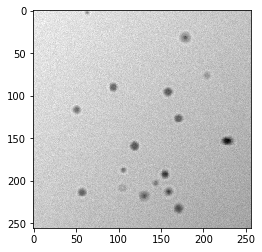

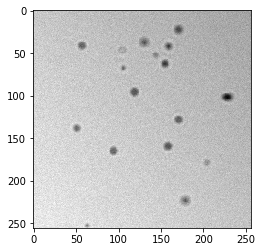

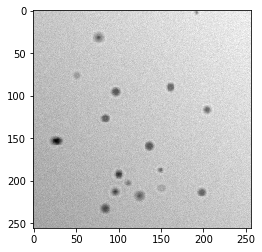

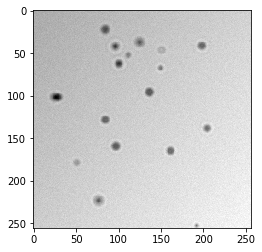

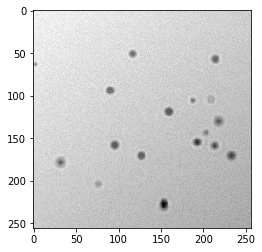

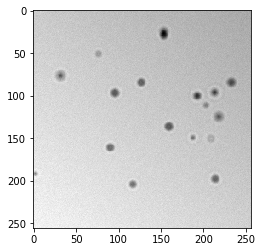

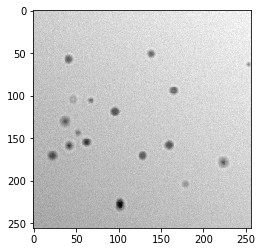

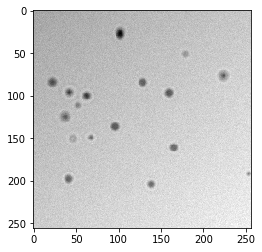

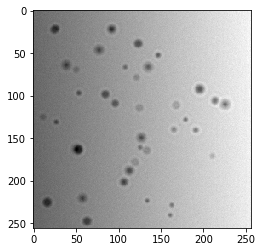

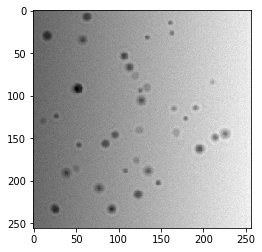

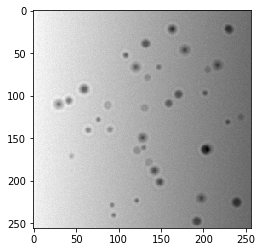

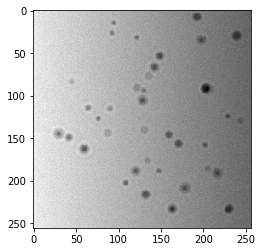

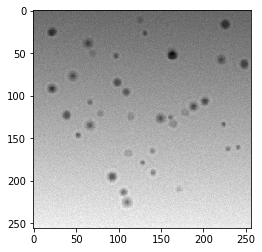

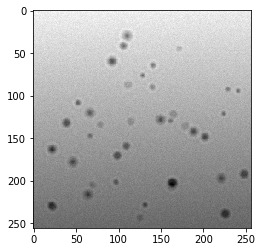

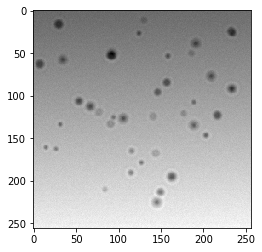

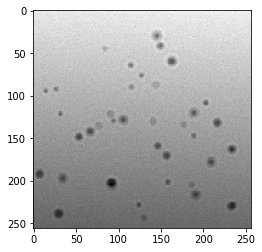

In [10]:
for i in range(16):
    image_of_particles.update()
    image_of_particles.plot(cmap="gray")

## 7. Create the target images

We define a function that uses the generated images to create the target images to be used in the training. The target is a image of shape (256, 256, 3), where the last dimension represents three classes. In other words, each pixel in the input image is classified into one of three classes. The first class is the null-class, that is, the class of a pixel that belongs to no other class. The second class is 1 if the pixel is within 3 pixels of the center of a small particle, while the third class is 1 if the pixel is within 3 pixels of a large particle.

We also show images and targets side by side.

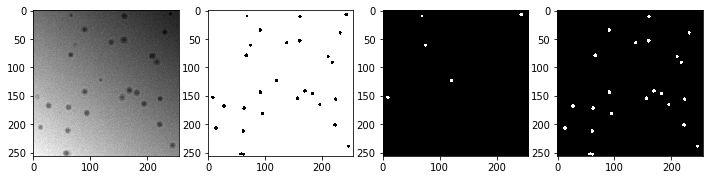

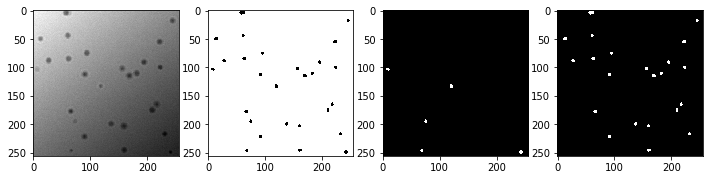

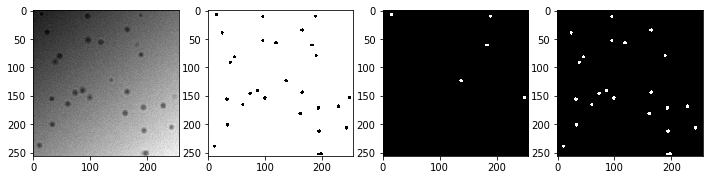

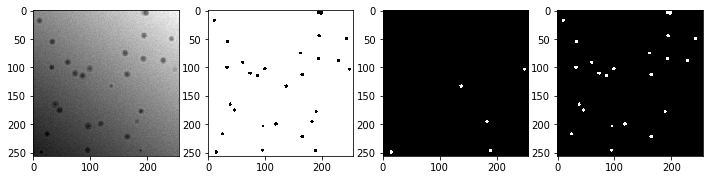

In [11]:
def get_target_image(image_of_particles):
    label = np.zeros((*image_of_particles.shape[:2], 3))
    
    
    X, Y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]), 
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]
            distance_map = (X - position[1])**2 + (Y - position[0])**2
            label[distance_map < 9, property["particle_type"] + 1] = 1
            
    label[..., 0] = 1 - np.max(label[..., 1:], axis=-1)
    
    return label

# Show images
for i in range(4):
    augmented_image.update()
    
    image_of_particles = augmented_image.resolve()
    
    label_of_particles = get_target_image(image_of_particles)
    
    plt.figure(figsize=(12, 9))
    
    plt.subplot(1, 4,1)
    plt.imshow(image_of_particles[..., 0], cmap="gray")
    
    plt.subplot(1,4,2)
    plt.imshow(label_of_particles[..., 0], cmap="gray")
    
    plt.subplot(1,4,3)
    plt.imshow(label_of_particles[..., 1], cmap="gray")
    
    plt.subplot(1,4,4)
    plt.imshow(label_of_particles[..., 2], cmap="gray")
    plt.show()

## 8. Define image generator

We define a generator that creates images and targets in batches of 8.

In [12]:
generator = Generator().generate(
    augmented_image, 
    get_target_image,
    batch_size=8
)

## 9. Define loss function

We also define a custom loss function. The loss function is binary crossentropy, where each class is wighted by 1-p, where p is is the proportion of all pixels in that class which is 1 in the label. This helps us avoid the local minima of classifying all pixels as the null-class.


In [16]:
import tensorflow.keras.backend as K
eps = 1e-6
def softmax_categorical(T, P):
    classwise_weight = K.mean(1 - T, axis=(1, 2), keepdims=True)
    true_error = K.mean(T * K.log(P + eps) * classwise_weight, axis=-1)
    return -K.mean(true_error)


## 10. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convoltional model used for image to image transformations. We add a softmax activation to the final layer. 

In [17]:
model = unet(
    (256, 256, 1), 
    conv_layers_dimensions=[8, 16, 32],
    base_conv_layers_dimensions=[32, 32], 
    number_of_outputs=3,
    output_activation="softmax",
    loss=softmax_categorical
)

W0206 13:29:30.822341 30500 deprecation.py:506] From C:\Users\bmidt\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 10. Train the model

The model is trained by calling `.fit()`.

In [18]:
model.fit(generator,
          epochs=100,
          steps_per_epoch=10,
          max_queue_size=0,
          workers=0)

Epoch 1/100
10/10 [==============================] - 29s 3s/step - loss: 0.0082
Epoch 2/100
10/10 [==============================] - 30s 3s/step - loss: 0.0101
Epoch 3/100
10/10 [==============================] - 26s 3s/step - loss: 0.0074
Epoch 4/100
10/10 [==============================] - 25s 2s/step - loss: 0.0066
Epoch 5/100
10/10 [==============================] - 26s 3s/step - loss: 0.0075
Epoch 6/100
10/10 [==============================] - 28s 3s/step - loss: 0.0069
Epoch 7/100
10/10 [==============================] - 27s 3s/step - loss: 0.0056
Epoch 8/100
10/10 [==============================] - 31s 3s/step - loss: 0.0067
Epoch 9/100
10/10 [==============================] - 30s 3s/step - loss: 0.0051
Epoch 10/100
10/10 [==============================] - 26s 3s/step - loss: 0.0031
Epoch 11/100
10/10 [==============================] - 27s 3s/step - loss: 0.0028
Epoch 12/100
10/10 [==============================] - 29s 3s/step - loss: 0.0038
Epoch 13/100
10/10 [=================

KeyboardInterrupt: 

## 11. Visualize the model performance

Finally we evaluate the model performance by showing the model output beside the input image and the ground truth.

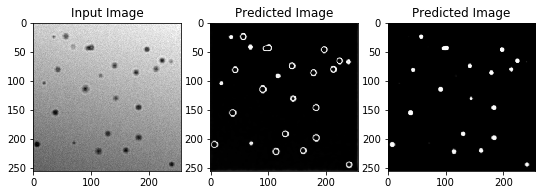

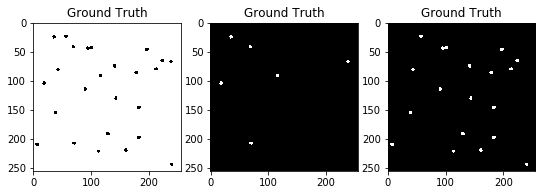

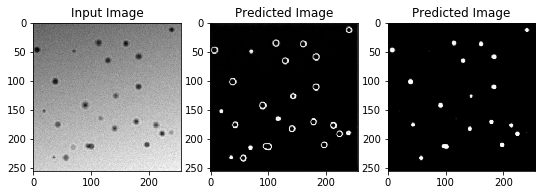

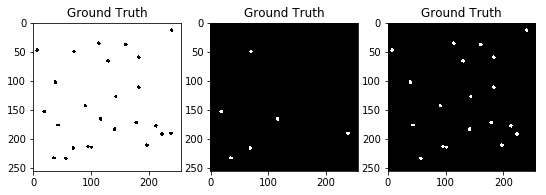

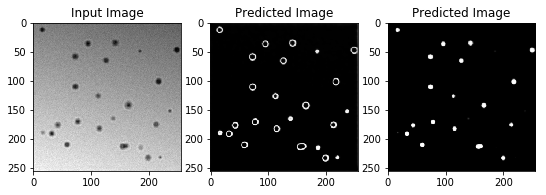

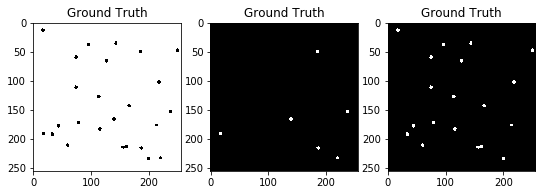

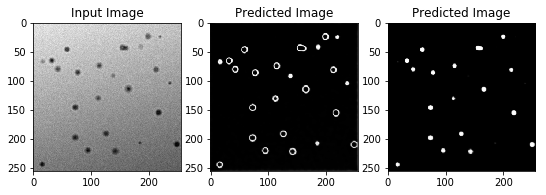

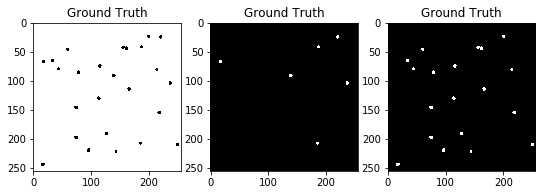

In [19]:
generator = Generator().generate(
    augmented_image, 
    get_target_image,
    batch_size=4
)

input_image, target_image = next(generator)


for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    plt.figure(figsize=(9, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image[i, :, :, 0], cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image[i, :, :, 1], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_image[i, :, :, 2], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.show()
    
    plt.figure(figsize=(9, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(target_image[i, :, :, 0], cmap="gray", vmin=0, vmax=1)
    plt.title("Ground Truth")
    
    plt.subplot(1, 3, 2)
    plt.imshow(target_image[i, :, :, 1], cmap="gray", vmin=0, vmax=1)
    plt.title("Ground Truth")
    
    plt.subplot(1, 3, 3)
    plt.imshow(target_image[i, :, :, 2], cmap="gray", vmin=0, vmax=1)
    plt.title("Ground Truth")


    